In [1]:
import argparse
import os
# from dgl.data import register_data_args
import logging
import fire
from optim import trainer, TUtrainer, AEtrainer, Mytrainer
from optim.loss import loss_function,init_center
from datasets import dataloader_pyg as dataloader
# from datasets import TUloader_pyg as TUloader
from datasets import Myloader
from networks_pyg.init import init_model
import numpy as np
import torch
# from dgl import random as dr

In [2]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.5,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=50,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True

# if args.dataset in ('citeseer' + 'reddit'):
#     args.normal_class=3
# if args.dataset in ('cora' + 'pubmed'):
#     args.normal_class=2
# if args.dataset in 'TU_PROTEINS_full':
#     args.normal_class=0

In [4]:
def get_output(train_loader, val_loader, test_loader, m):
    output_all = []
    for ix, data in tqdm(enumerate(train_loader)):
        data.cuda()
        output = m(data)
        output_all.append(output)
    output_all = torch.cat(output_all, dim=0)
    output_all = output_all.cpu().detach().numpy()
    output_all.shape

    normal_all = []
    for ix, data in tqdm(enumerate(val_loader)):
        data.cuda()
        output = m(data)
        normal_all.append(output)
    normal_all = torch.cat(normal_all, dim=0)
    normal_all = normal_all.cpu().detach().numpy()

    abnormal_all = []
    for ix, data in tqdm(enumerate(test_loader)):
        data.cuda()
        output = m(data)
        abnormal_all.append(output)
    abnormal_all = torch.cat(abnormal_all, dim=0)
    abnormal_all = abnormal_all.cpu().detach().numpy()

    return output_all, normal_all, abnormal_all

In [5]:
def plot_pca(output_all, normal_all, abnormal_all, n_comp = 5):
    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(output_all)
    normal_pca = pca.transform(normal_all)
    abnormal_pca = pca.transform(abnormal_all)
    print(train_pca.shape, normal_pca.shape, abnormal_pca.shape)

    # for i in range(len(train_pca)):
    # for i in range(500):
        # plt.scatter(train_pca[i, 0], train_pca[i,1], color='tab:blue', s=15)
    for i in range(len(abnormal_pca)):
        plt.scatter(abnormal_pca[i, 0], abnormal_pca[i,1], color='tab:red', s=7)
    for i in range(len(normal_pca)):
        plt.scatter(normal_pca[i, 0], normal_pca[i,1], color='tab:green', s=15)
    # plt.xlim(-0.005, 0.005)
    # plt.ylim(-0.005, 0.005)
    plt.show()

In [6]:
def plot_tsne(output_all, normal_all, abnormal_all):
    tsne = TSNE(n_components=2)
    tsne_all = tsne.fit_transform(np.concatenate([output_all, normal_all, abnormal_all]))
    ixs = [len(output_all), len(normal_all), len(abnormal_all)]
    train_tsne = tsne_all[:ixs[0]]
    normal_tsne = tsne_all[ixs[0]:-ixs[2]]
    abnormal_tsne = tsne_all[-ixs[1]:]
    print(train_tsne.shape, normal_tsne.shape, abnormal_tsne.shape)

    # for i in range(len(train_tsne)):
    # for i in range(500):
        # plt.scatter(train_tsne[i, 0], train_tsne[i,1], color='tab:blue', s=15)
    for i in range(len(normal_tsne)):
        plt.scatter(normal_tsne[i, 0], normal_tsne[i,1], color='tab:green', s=15)
    for i in range(len(abnormal_tsne)):
        plt.scatter(abnormal_tsne[i, 0], abnormal_tsne[i,1], color='tab:red', s=7)

    # plt.xlim(-0.005, 0.005)
    # plt.ylim(-0.005, 0.005)
    plt.show()

In [7]:
output_all, normal_all, abnormal_all = get_output(train_loader, val_loader, test_loader, model_1)
plot_tsne(output_all, normal_all, abnormal_all)

NameError: name 'train_loader' is not defined

In [13]:
output_all, normal_all, abnormal_all = get_output(train_loader, val_loader, test_loader, model_50)
plot_tsne(output_all, normal_all, abnormal_all)

39it [00:00, 253.94it/s]
36it [00:00, 262.42it/s]
36it [00:00, 297.58it/s]


(2464, 2) (2288, 2) (2288, 2)


KeyboardInterrupt: 

In [ ]:
output_all, normal_all, abnormal_all = get_output(train_loader, val_loader, test_loader, model_100)
plot_tsne(output_all, normal_all, abnormal_all)


In [ ]:
output_all, normal_all, abnormal_all = get_output(train_loader, val_loader, test_loader, model)
plot_tsne(output_all, normal_all, abnormal_all)


# Monitoring Training

In [67]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [68]:
from networks_pyg.GCN import *
from datasets.Myloader import profile_loader
from optim import Mytrainer
from optim.loss import loss_function,init_center
from datasets import dataloader_pyg as dataloader
from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
from networks_pyg.init import init_model
from networks_pyg.GCN import *
from networks_pyg.GraphSAGE import *

In [134]:
# args.module = 'GraphSAGE_gc'
# args.module = 'GCN_gc'
args.module = 'GCN_traffic'
input_dim = 12
model = init_model(args, input_dim)


Parameter number of GCN_traffic Net is: 14144


In [135]:
for ix, data in enumerate(train_loader):
    out = model(data.cuda())
    print(out)
    break

torch.Size([1344, 32]) torch.Size([1344, 32])
torch.Size([1344, 64])
tensor([[-0.0778, -0.0392, -0.0478,  ..., -0.1633,  0.3419, -0.2005],
        [-0.2759, -0.3963,  0.0280,  ..., -0.5180,  1.1643, -0.5499],
        [-0.2075, -0.0965,  0.0574,  ..., -0.0701,  0.4550, -0.2050],
        ...,
        [-0.1502, -0.2478, -0.0146,  ..., -0.0851,  0.3041, -0.1543],
        [-0.1822, -0.1681,  0.0087,  ..., -0.4658,  1.1416, -0.2870],
        [-0.0297, -0.0538, -0.0946,  ..., -0.0799,  0.1608, -0.0704]],
       device='cuda:0', grad_fn=<DivBackward0>)


In [10]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.5,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=50,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [45]:
# args.dataset = 'Accident_speed_standard'
# args.dataset = 'test'
args.dataset = 'Accident_standard'
args.module = 'GCN_gc'
args.normalize = 'standard'
args.nu = 0.2
train_mode = 'all'
args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}'

In [22]:
checkpoints_path=f'./checkpoints/{args.exp_name}+bestcheckpoint.pt'
logging.basicConfig(filename=f"./log/{args.dataset}+OC-{args.module}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
logger=logging.getLogger('OCGNN')

In [12]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('datasets/data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [13]:
    target_sid = 1030001902
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'profile'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

    # define anomaly label
    labels = []
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

/tmp/ipykernel_3348090/2986941087.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


<Axes: xlabel='datetime'>

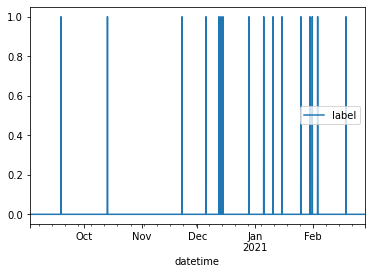

In [14]:
label_df.plot()

In [15]:
from datasets.Myloader import profile_loader
train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
len(train_loader), len(val_loader), len(test_loader)

train dataset


  0%|          | 0/17256 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)
100%|██████████| 17256/17256 [00:19<00:00, 887.55it/s]


val dataset


100%|██████████| 8628/8628 [00:08<00:00, 1036.97it/s]


test dataset


100%|██████████| 25908/25908 [00:25<00:00, 1034.71it/s]


(17, 135, 405)

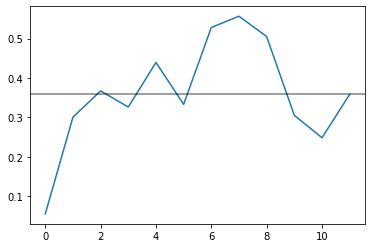

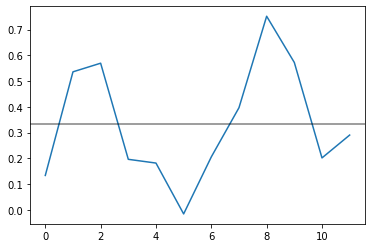

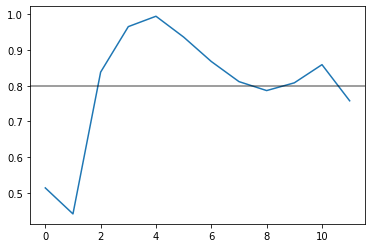

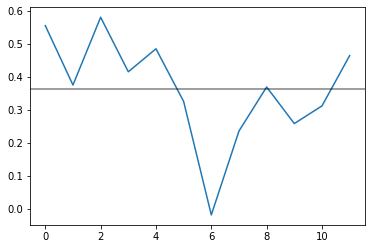

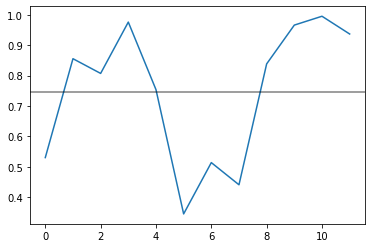

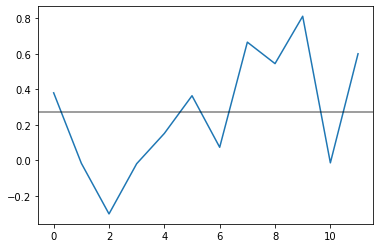

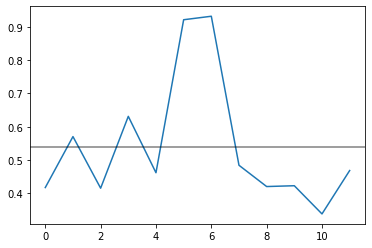

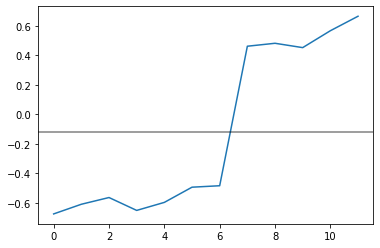

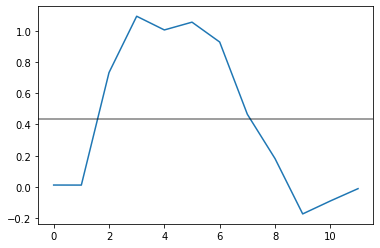

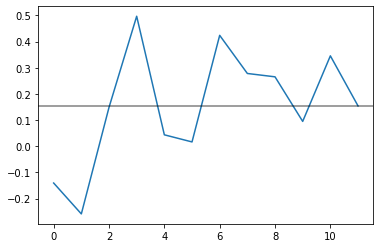

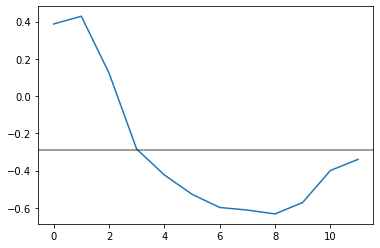

In [16]:
## Normal Data Plot
for i, data in enumerate(train_loader):
    plt.figure()
    plt.plot(data.x[0])
    plt.axhline(data.x[0].mean(), alpha=0.5, color='k')
    if i == 10:
        break

## Incident Data Plot
# for ix, row in accident_case.iterrows():
#     t = row['created']
#     plt.figure()
#     plt.plot(df_all_norm.loc[(df_all_norm.index > t+timedelta(minutes=-60)) & (df_all_norm.index <= t+timedelta(minutes=60))][accident_sid])

In [23]:
input_dim = 12
model = init_model(args, input_dim)
model_1 = init_model(args, input_dim)
model_50 = init_model(args, input_dim)
model_100 = init_model(args, input_dim)

Parameter number of GCN_gc Net is: 7072
Parameter number of GCN_gc Net is: 7072
Parameter number of GCN_gc Net is: 7072
Parameter number of GCN_gc Net is: 7072


In [24]:
model.load_state_dict(torch.load(checkpoints_path)['model'])
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']
model, data_center, radius

(GCN_gc(
   (layers): ModuleList(
     (0): GCNConv(12, 64)
     (1): GCNConv(64, 64)
     (2): GCNConv(64, 32)
   )
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 tensor([-0.1464,  0.0439,  0.3396,  0.2904, -0.4310, -0.2881, -0.0448, -0.5746,
          0.5766, -0.2636, -0.3288, -0.1468,  0.6621,  0.1190,  0.4929,  0.2431,
          1.0296,  0.4725, -0.1725, -0.1545, -0.2960, -0.0450, -0.7222,  0.1396,
          0.3087,  0.1452, -0.0505, -0.1994,  0.5785, -0.1129, -0.0354,  0.1710],
        device='cuda:0'),
 tensor(0.0005, device='cuda:0', dtype=torch.float64))

In [15]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
# radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
radius = np.quantile(np.sqrt(dist_all), 0.95)
radius

135it [00:00, 265.90it/s]


0.2210316628217697

In [25]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

405it [00:02, 169.36it/s]


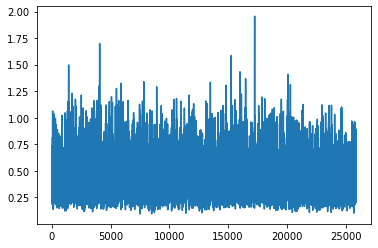

In [26]:
plt.plot(score_all)

In [18]:
# def Cumulative(lists, window=12):
#     cu_list = []
#     length = len(lists)
#     cu_list = [sum(lists[x-window:x]) for x in range(window, length)]
#     return cu_list + [0]*window

# plt.plot(Cumulative(score_all, window=2))
# score_all = Cumulative(score_all, window=2)

In [19]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

AUC score 0.496406958430156
FAR score 0.029268102067132977
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     25591
           1       0.01      0.02      0.01       317

    accuracy                           0.96     25908
   macro avg       0.50      0.50      0.50     25908
weighted avg       0.98      0.96      0.97     25908



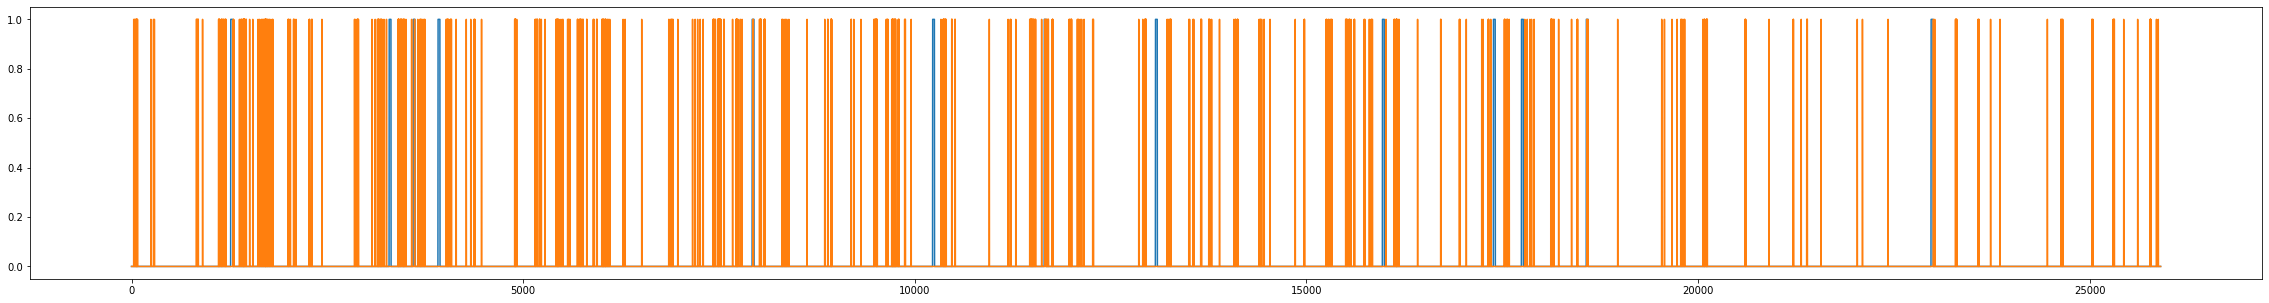

In [20]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
CM = confusion_matrix(true, pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FAR = FP / (FP+TN)
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(pred)
cm = confusion_matrix(true, pred)
print('AUC score', roc_auc_score(true, pred))
print('FAR score', FAR)
print(classification_report(true, pred))

AUC score 0.636785507326055
FAR score 0.029268102067132977
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     25591
           1       0.11      0.30      0.17       317

    accuracy                           0.96     25908
   macro avg       0.55      0.64      0.57     25908
weighted avg       0.98      0.96      0.97     25908



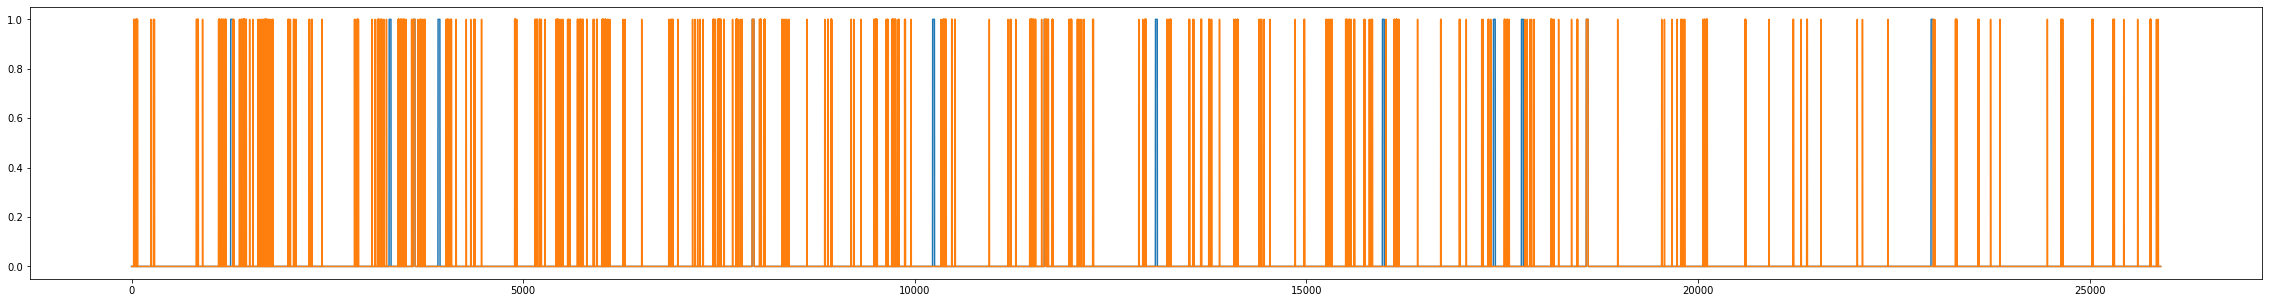

In [21]:
true = label_all
new_pred = adjust_predictions(pred, true)
CM = confusion_matrix(true, new_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FAR = FP / (FP+TN)
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(adjust_predictions(new_pred, true))
print('AUC score', roc_auc_score(true, new_pred))
print('FAR score', FAR)
print(classification_report(true, new_pred))

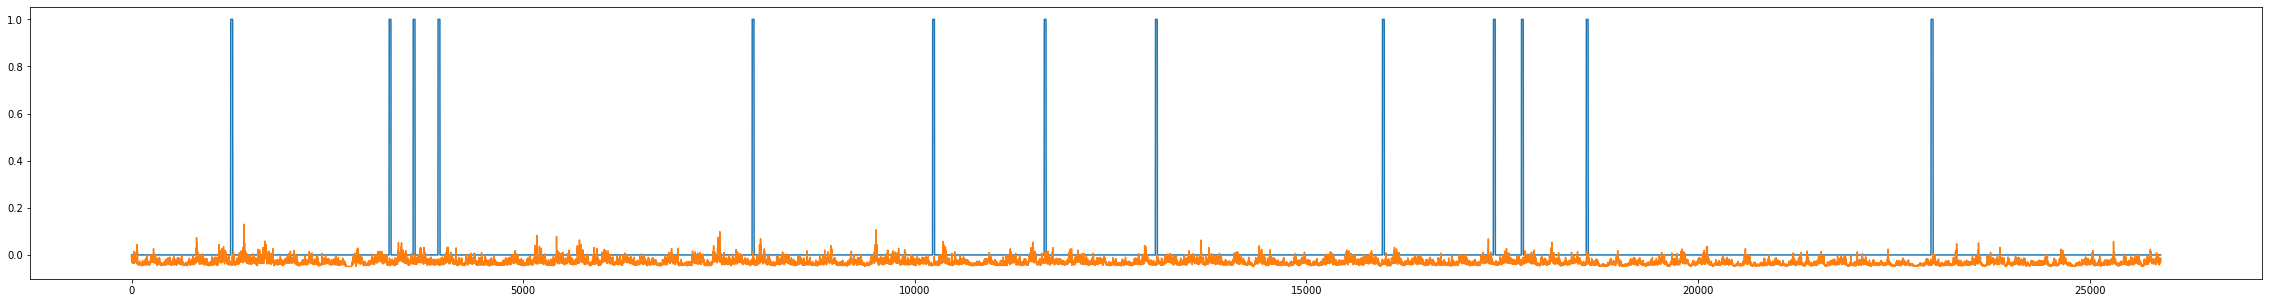

In [23]:
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(score_all)

In [95]:
label_df['weekday'] = label_df.index.weekday
label_df['timestamp'] = label_df.index.time
test_label_df = label_df[label_df.index >= datetime(2020, 12, 1)].iloc[12:]

In [96]:
profile_mean.reset_index(inplace=True)

In [97]:
pred = list(map(int, [s>0 for s in score_all]))
new_pred = []
for i, dt in enumerate(test_label_df.index):
    weekday = test_label_df.iloc[i]['weekday']
    timestamp = test_label_df.iloc[i]['timestamp']
    if pred[i] == 1:
        if profile_mean[(profile_mean.weekday == 0) & (profile_mean.timestamp == timestamp)].iloc[:, 2:].mean(axis=1).item() < 50:
            new_pred.append(0)
        else:
            new_pred.append(1)
    else:
        new_pred.append(0)


AUC score 0.4967069949054201
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25591
           1       0.01      0.01      0.01       317

    accuracy                           0.98     25908
   macro avg       0.50      0.50      0.50     25908
weighted avg       0.98      0.98      0.98     25908



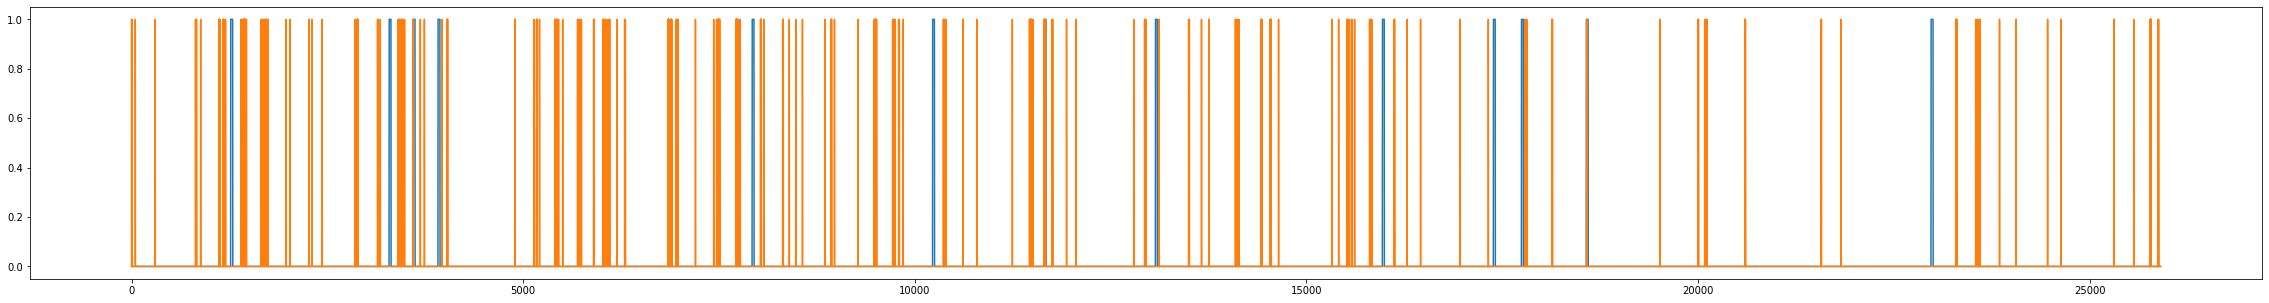

In [98]:
true = label_all
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(new_pred)
print('AUC score', roc_auc_score(true, new_pred))
print(classification_report(true, new_pred))

AUC score 0.5692621999527387
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25591
           1       0.13      0.15      0.14       317

    accuracy                           0.98     25908
   macro avg       0.56      0.57      0.56     25908
weighted avg       0.98      0.98      0.98     25908



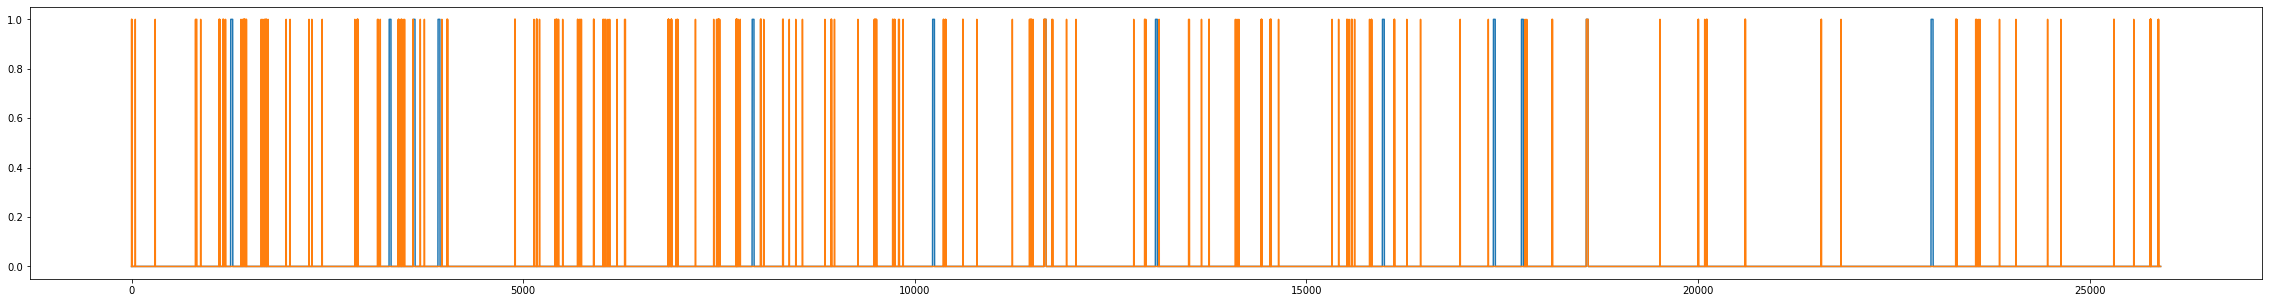

In [99]:
true = label_all
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(adjust_predictions(new_pred, true))
print('AUC score', roc_auc_score(true, adjust_predictions(new_pred, true)))
print(classification_report(true, adjust_predictions(new_pred, true)))

In [63]:
# checkpoints_path=f'./checkpoints/{args.exp_name}+epoch100.pt'
checkpoints_path=f'./checkpoints/{args.exp_name}+bestcheckpoint.pt'
print(checkpoints_path)
model_100 = init_model(args, 12)
model_100.load_state_dict(torch.load(checkpoints_path)['model'])
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']

out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model_100(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

./checkpoints/standard_all_GCN_gc_0.2+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


405it [00:01, 298.32it/s]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd58ac42ee0>
Traceback (most recent call last):
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


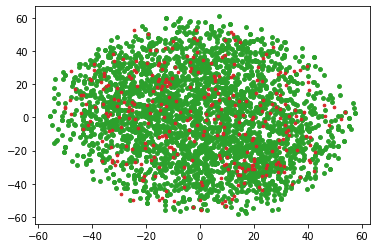

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_all = tsne.fit_transform(np.concatenate(out_all))

true = label_all
normal = np.where(true == 0)
abnormal = np.where(true == 1)

normal_tsne = tsne_all[normal[0]]
abnormal_tsne = tsne_all[abnormal[0]]
# for i in range(len(normal_tsne)):
for i in np.random.choice(len(normal_tsne), 3000):
    plt.scatter(normal_tsne[i, 0], normal_tsne[i,1], color='tab:green', s=15)
for i in range(len(abnormal_tsne)):
    plt.scatter(abnormal_tsne[i, 0], abnormal_tsne[i,1], color='tab:red', s=7)

# plt.xlim(-0.005, 0.005)
# plt.ylim(-0.005, 0.005)
plt.show()

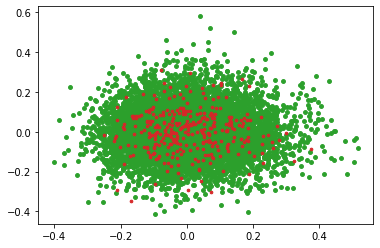

In [58]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(np.concatenate(out_all))

normal = np.where(true == 0)
abnormal = np.where(true == 1)

normal_pca = pca_all[normal[0]]
abnormal_pca = pca_all[abnormal[0]]
# for i in range(len(normal_tsne)):
for i in range(10000):
    plt.scatter(normal_pca[i, 0], normal_pca[i,1], color='tab:green', s=15)
for i in range(len(abnormal_tsne)):
    plt.scatter(abnormal_pca[i, 0], abnormal_pca[i,1], color='tab:red', s=7)

# plt.xlim(-0.005, 0.005)
# plt.ylim(-0.005, 0.005)
plt.show()

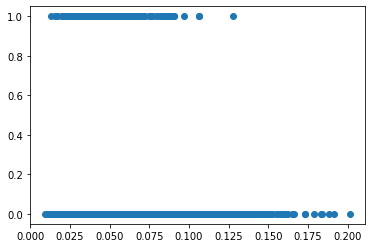

In [65]:
plt.scatter(dist_all, label_all)

## Random Case

AUC score 0.5046079759655252
FAR score 0.050720956586299874
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     25591
           1       0.01      0.06      0.02       317

    accuracy                           0.94     25908
   macro avg       0.50      0.50      0.50     25908
weighted avg       0.98      0.94      0.96     25908



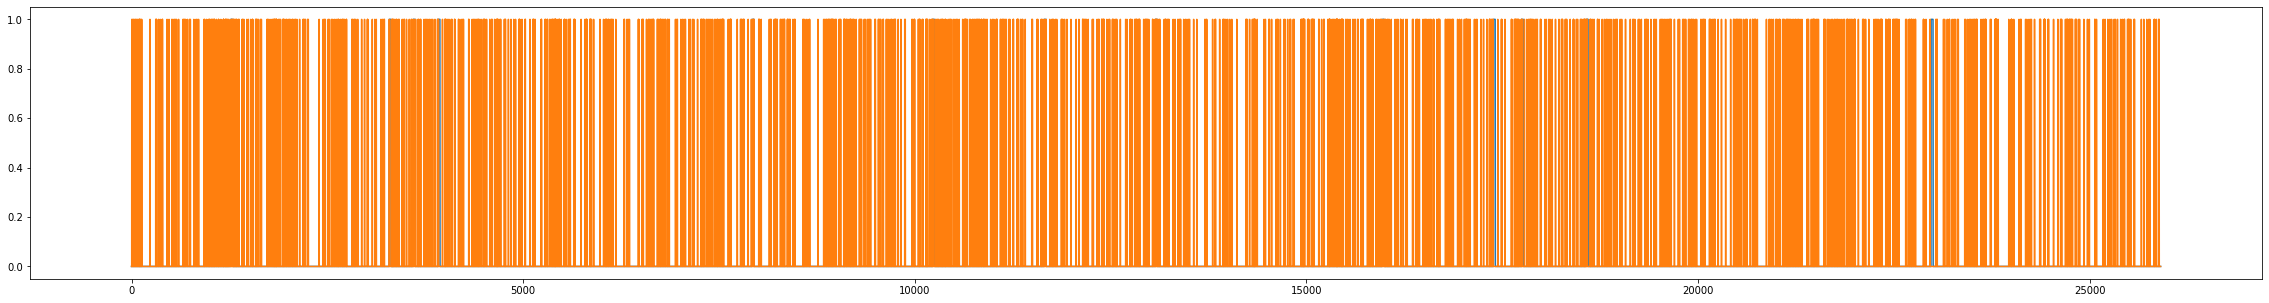

In [157]:
true = label_all
pred = np.random.choice(np.arange(2), len(true), p=[0.95, 0.05])
CM = confusion_matrix(true, pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FAR = FP / (FP+TN)
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(pred)
print('AUC score', roc_auc_score(true, pred))
print('FAR score', FAR)
print(classification_report(true, pred))

AUC score 0.8957751683945473
FAR score 0.050720956586299874
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     25591
           1       0.17      0.84      0.28       317

    accuracy                           0.95     25908
   macro avg       0.58      0.90      0.63     25908
weighted avg       0.99      0.95      0.96     25908



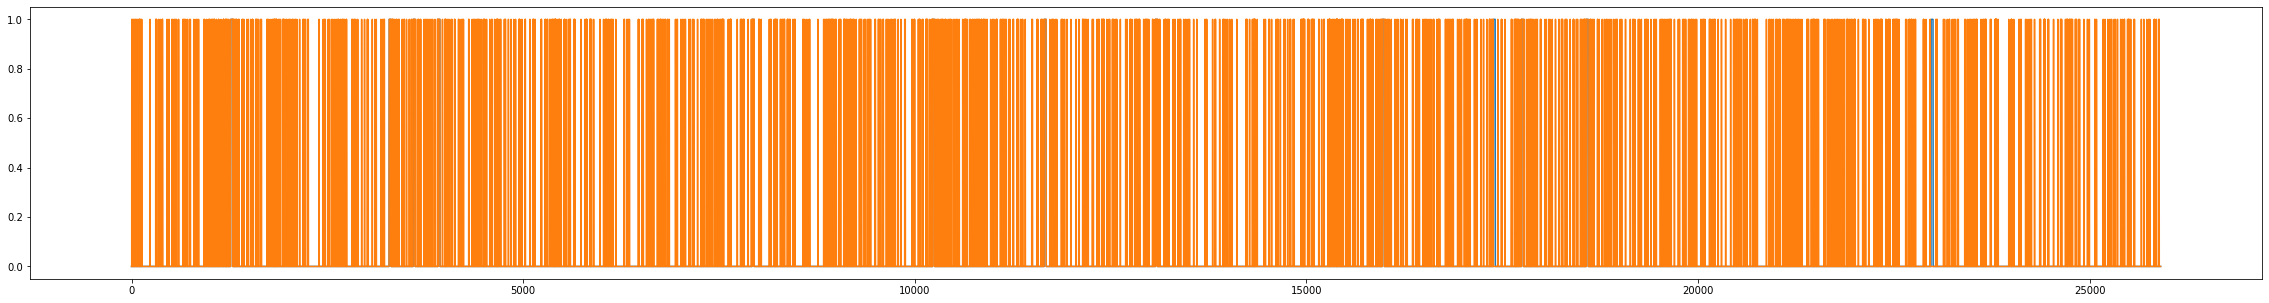

In [158]:
true = label_all
new_pred = adjust_predictions(pred, true)
CM = confusion_matrix(true, new_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FAR = FP / (FP+TN)
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(adjust_predictions(new_pred, true))
print('AUC score', roc_auc_score(true, new_pred))
print('FAR score', FAR)
print(classification_report(true, new_pred))

## Profile Detection Case

In [33]:
for ix, data in enumerate(test_loader):
    print(data.x.shape())
    break

TypeError: 'torch.Size' object is not callable

In [ ]:
pred = list(map(int, [s>0 for s in score_all]))
new_pred = []
for i, dt in enumerate(test_label_df.index):
    weekday = test_label_df.iloc[i]['weekday']
    timestamp = test_label_df.iloc[i]['timestamp']
    if pred[i] == 1:
        if profile_mean[(profile_mean.weekday == 0) & (profile_mean.timestamp == timestamp)].iloc[:, 2:].mean(axis=1).item() < 50:
            new_pred.append(0)
        else:
            new_pred.append(1)
    else:
        new_pred.append(0)
